In [1]:
!git clone https://github.com/FurkanAtass/Tracking-People-in-Aerial-Footage

Cloning into 'Tracking-People-in-Aerial-Footage'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 88 (delta 39), reused 69 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 2.89 MiB | 46.22 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!cd /content/Tracking-People-in-Aerial-Footage/faster_rcnn/ && cp /content/drive/MyDrive/combined_coco.zip . && unzip combined_coco.zip && rm combined_coco.zip

Streaming output truncated to the last 5000 lines.
  inflating: combined_coco/train/labels/visdrone-det_9999999_00805_d_0000368.txt  
  inflating: __MACOSX/combined_coco/train/labels/._visdrone-det_9999999_00805_d_0000368.txt  
  inflating: combined_coco/train/labels/visdrone-det_0000126_03828_d_0000129.txt  
  inflating: __MACOSX/combined_coco/train/labels/._visdrone-det_0000126_03828_d_0000129.txt  
  inflating: combined_coco/train/labels/mot20_MOT20-01_000360.txt  
  inflating: __MACOSX/combined_coco/train/labels/._mot20_MOT20-01_000360.txt  
  inflating: combined_coco/train/labels/okutama_1.1.3_000945.txt  
  inflating: __MACOSX/combined_coco/train/labels/._okutama_1.1.3_000945.txt  
  inflating: combined_coco/train/labels/okutama_2.1.3_001620.txt  
  inflating: __MACOSX/combined_coco/train/labels/._okutama_2.1.3_001620.txt  
  inflating: combined_coco/train/labels/visdrone-det_9999998_00229_d_0000185.txt  
  inflating: __MACOSX/combined_coco/train/labels/._visdrone-det_9999998_002

In [3]:
import os
os.chdir("/content/Tracking-People-in-Aerial-Footage/faster_rcnn")

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from engine import train_one_epoch, evaluate
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

EPOCHS = 30 
BATCH_SIZE = 2
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
EARLY_STOPPING_PATIENCE = 5  

TRAIN_IMAGE_DIR = "combined_coco/train/images"
TRAIN_ANNOTATION_PATH = "combined_coco/train.json"
VAL_IMAGE_DIR = "combined_coco/valid/images"
VAL_ANNOTATION_PATH = "combined_coco/val.json"

train_transform = transforms.Compose([
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoDetectionDataset(Dataset):
    # Init function: loads annotation file and prepares list of image IDs
    def __init__(self, image_dir, annotation_path, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # Extract bounding boxes and labels from annotations
        boxes = []
        labels = []
        for obj in annotations:
            xmin, ymin, width, height = obj['bbox']
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            # Shift label by +1 so 'person' becomes 1 (0 is background)
            labels.append(obj['category_id'] + 1)

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor([obj['area'] for obj in annotations],    dtype=torch.float32)
        iscrowd = torch.as_tensor([obj.get('iscrowd', 0) for obj in annotations], dtype=torch.int64)

        # Package everything into a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


train_dataset = CocoDetectionDataset(
    image_dir=TRAIN_IMAGE_DIR,
    annotation_path=TRAIN_ANNOTATION_PATH,
    transforms=train_transform
)

val_dataset = CocoDetectionDataset(
    image_dir=VAL_IMAGE_DIR,
    annotation_path=VAL_ANNOTATION_PATH,
    transforms=val_transform
)

# Load dataset with DataLoaders, you can change batch_size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [5]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Load a pre-trained Faster R-CNN model with ResNet50 backbone and FPN
# Using 'weights' as 'pretrained' is deprecated
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

# Number of classes in the dataset (including background)
# +1 for bg class
num_classes = len(train_dataset.coco.getCatIds()) + 1
print(f"Num classes: {num_classes}")

# Number of input features for the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# Learning rate scheduler - reduce LR by 10x after 20 epochs

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 243MB/s]


Num classes: 2


In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

# Load trained Faster R-CNN model
model.load_state_dict(torch.load("/content/Tracking-People-in-Aerial-Footage/faster_rcnn/model_epoch_7.pth"))
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [13]:
from engine import train_one_epoch, evaluate

# Number of epochs for training
num_epochs = 10

# Loop through each epoch
for epoch in range(7, num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model only on the validation dataset, not training
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # save the model after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")



Epoch 8/10
Epoch: [7]  [   0/4489]  eta: 0:20:34  lr: 0.005000  loss: 0.5869 (0.5869)  loss_classifier: 0.1822 (0.1822)  loss_box_reg: 0.2879 (0.2879)  loss_objectness: 0.0382 (0.0382)  loss_rpn_box_reg: 0.0786 (0.0786)  time: 0.2751  data: 0.0320  max mem: 2925
Epoch: [7]  [  25/4489]  eta: 0:20:57  lr: 0.005000  loss: 0.7158 (0.6900)  loss_classifier: 0.1570 (0.1766)  loss_box_reg: 0.3075 (0.3165)  loss_objectness: 0.0502 (0.0583)  loss_rpn_box_reg: 0.1153 (0.1387)  time: 0.2807  data: 0.0338  max mem: 3272
Epoch: [7]  [  50/4489]  eta: 0:20:42  lr: 0.005000  loss: 0.7154 (0.7126)  loss_classifier: 0.1769 (0.1840)  loss_box_reg: 0.3178 (0.3391)  loss_objectness: 0.0396 (0.0566)  loss_rpn_box_reg: 0.0923 (0.1329)  time: 0.2777  data: 0.0307  max mem: 3322
Epoch: [7]  [  75/4489]  eta: 0:20:37  lr: 0.005000  loss: 0.7059 (0.7080)  loss_classifier: 0.1917 (0.1844)  loss_box_reg: 0.3035 (0.3441)  loss_objectness: 0.0522 (0.0531)  loss_rpn_box_reg: 0.0919 (0.1264)  time: 0.2815  data: 0.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


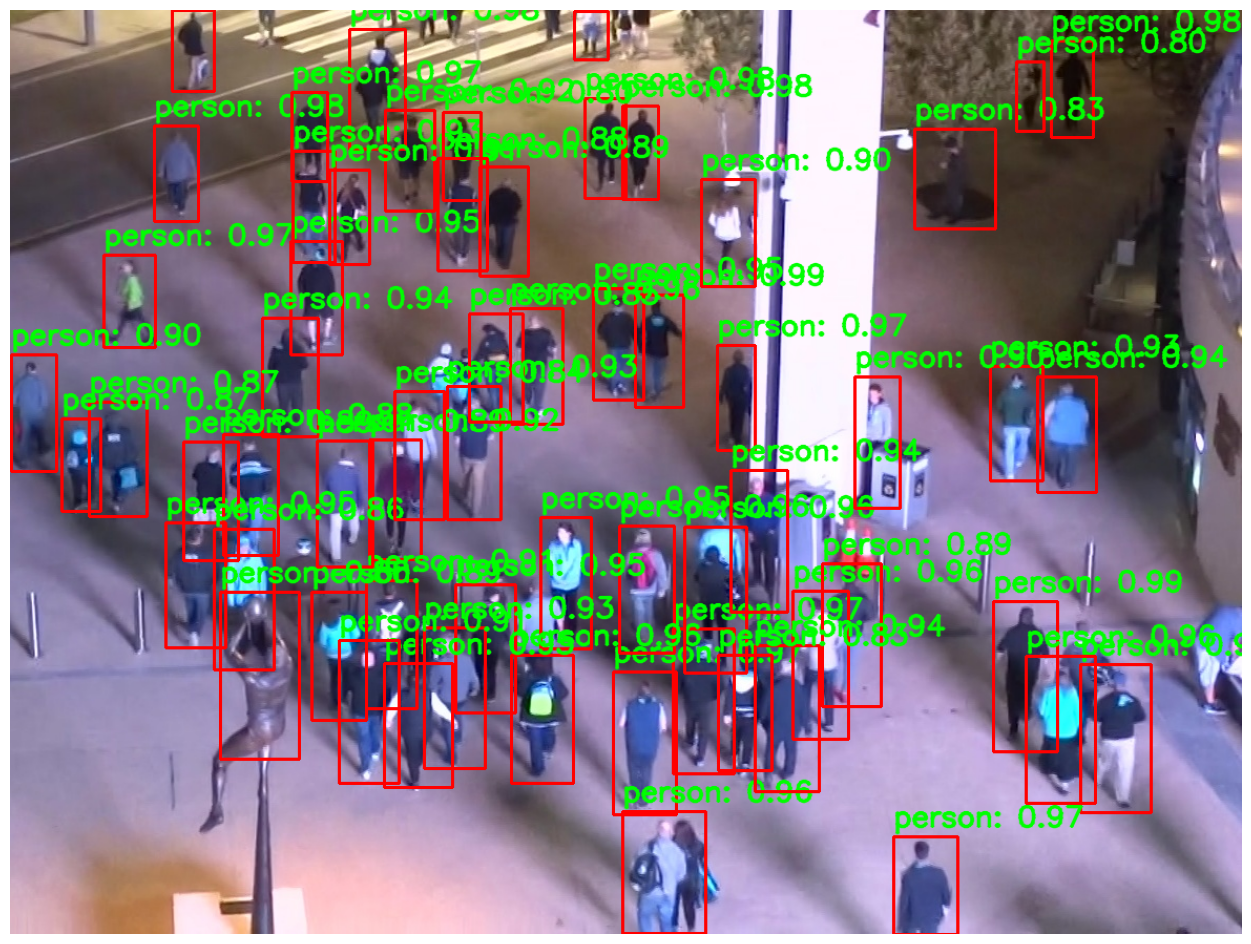

In [14]:
from torchvision import models, transforms

# class names
label_list= ["","person"]

# Number of classes (include background)
num_classes = 2   # this has to be 5 in normally, but because of some labeling issues in dataset this is 6.

# Load the same model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

# Load trained Faster R-CNN model
model.load_state_dict(torch.load("/content/Tracking-People-in-Aerial-Footage/faster_rcnn/model_epoch_5.pth"))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = "/content/Tracking-People-in-Aerial-Footage/faster_rcnn/combined_coco/valid/images/mot20_MOT20-03_000001.jpg" # CHANGE this to your image path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)


transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# detection data
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

"""
Higher threshold give you more accurate detections,
but number of predictions is reduced; there is a simple trade-off
"""
threshold = 0.8
for i in range(len(boxes)):
    if scores[i] > threshold:
        box = boxes[i].cpu().numpy().astype(int)
        label = label_list[labels[i]]
        score = scores[i].item()


        text = f"{label}: {score:.2f}"
        cv2.putText(image_bgr, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 255, 0), 2, cv2.LINE_AA)

        # Draw bbox and label
        cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)


# Convert BGR --> RGB
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Show image with larger figure size
plt.figure(figsize=(16, 12))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [10]:
# Inspect the dataset category IDs and a sample target
print("Dataset Categories:", train_dataset.coco.cats)
print("Category IDs:", train_dataset.coco.getCatIds())

# Check the labels of the first training sample
img, target = train_dataset[0]
print("\nSample Image ID:", target['image_id'])
print("Sample Labels:", target['labels'])
print("Sample Boxes:", target['boxes'])

Dataset Categories: {0: {'supercategory': 'none', 'name': 'person', 'id': 0}}
Category IDs: [0]

Sample Image ID: 0
Sample Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Sample Boxes: tensor([[ 757.0003,  691.9998,  853.0003,  901.0002],
        [ 666.9994,  681.9995,  766.9987,  903.9999],
        [ 343.0003,  818.0001,  470.0006, 1076.0002],
        [ 805.9997,  524.0004,  876.9994,  696.0001],
        [ 195.9994,  814.0003,  337.0003, 1078.9999],
        [1164.0010,  605.0004, 1233.0000,  801.9999],
        [ 952.9997,  605.0004, 1032.0000,  804.0001],
        [1432.9996,  511.0004, 1492.9996,  609.0007],
        [1650.0010,  832.9997, 1750.0004, 1075.9996],
        [1025.0006,  608.0006, 1110.0010,  804.0001],
        [1468.9996,  641.0000, 1550.0006,  845.0001],
        [1585.0004,  674.9995, 1695.0010,  911.0000],
        [1047.9994,  435.9998, 1098.0000,  560.0000],
        [1090.9996,  547.0000, 1167.9994,  725